In [1]:
import pandas as pd
import numpy as np

In [2]:
raw_data = pd.read_csv('./test_data.csv')
raw_label = pd.read_csv('./test_label.csv')

In [3]:
data = raw_data.drop(columns=['id'])
data

,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
0,0.0,0.000000,2.249354,6.873001,9.621334,0.0,9.786846,0.701150,0.0,0.0,...,4.984740,7.940642,10.724394,2.045757,8.975857,12.607631,10.701263,8.879467,4.211160,0.000000
1,0.0,4.094565,4.704501,7.545559,9.752299,0.0,8.595821,0.859970,0.0,0.0,...,4.598568,7.654557,10.089887,7.107677,8.832156,12.816038,9.317229,9.461801,9.258929,0.000000
2,0.0,4.143565,3.043834,6.211337,8.791908,0.0,7.691960,1.154907,0.0,0.0,...,7.238070,9.143623,10.484390,4.344878,10.448746,10.912785,10.373365,10.094183,3.857364,0.000000
3,0.0,2.215150,1.868845,6.287153,9.273963,0.0,8.317725,1.544040,0.0,0.0,...,6.791345,9.454223,10.475004,6.362757,10.604674,10.969149,10.896014,10.507914,8.706012,0.000000
4,0.0,2.988103,1.811471,5.763507,8.604753,0.0,7.335855,0.787850,0.0,0.0,...,7.156478,8.986857,10.444663,1.824849,10.053587,11.873652,10.603654,9.608950,5.026884,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
327,0.0,4.869200,4.087717,6.369039,9.684507,0.0,7.929903,0.000000,0.0,0.0,...,6.029753,8.875998,10.766554,6.197223,10.013392,9.939708,10.591896,10.316972,3.412782,0.000000
328,0.0,4.288388,3.452490,7.209151,9.875620,0.0,7.332717,0.416948,0.0,0.0,...,6.780349,9.205859,10.176497,6.670727,10.246230,10.790014,10.698991,10.081523,4.376693,0.000000
329,0.0,3.249582,3.707492,8.185901,9.504082,0.0,7.536589,1.811101,0.0,0.0,...,5.719386,8.610704,10.485517,3.589763,9.350636,12.180944,10.681194,9.466711,4.677458,0.586693
330,0.0,2.590339,2.787976,7.318624,9.987136,0.0,9.213464,0.000000,0.0,0.0,...,5.785237,8.605387,11.004677,4.745888,9.626383,11.198279,10.335513,10.400581,5.718751,0.000000


In [4]:
label = raw_label.drop(columns=['id'])
label

,Class
0,KIRC
1,BRCA
2,KIRC
3,BRCA
4,KIRC
...,...
327,PRAD
328,PRAD
329,COAD
330,PRAD


In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

In [6]:
# 將數據轉換成圖像矩陣格式
img_shape = (200, 103)  # 圖像大小

zeros_array = np.zeros((data.shape[0], (img_shape[0] * img_shape[1] - data.shape[1])))
data = np.hstack((data, zeros_array))

In [7]:
num_channels = 1  # 單通道灰度圖像
data = data.reshape((data.shape[0], img_shape[0], img_shape[1], 1))

print(data.shape)  # (樣本數, 高度, 寬度, 通道數)

(332, 200, 103, 1)


(332, 200, 103, 1)


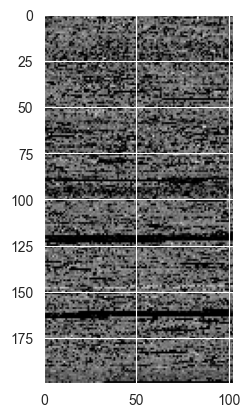

In [8]:
print(data.shape)  # (樣本數, 高度, 寬度, 通道數)
import matplotlib.pyplot as plt

# Reshape to image format
img = data[0].reshape(200, -1)

# Display image as grayscale
plt.imshow(img, cmap='gray')
plt.show()

In [9]:
# 載入模型
from tensorflow import keras

model = keras.models.load_model('./CNN_Gene_2023-05-11_18-14-51.h5')

optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_16 (Conv1D)          (None, 198, 8)            2480      
                                                                 
 max_pooling1d_16 (MaxPoolin  (None, 99, 8)            0         
 g1D)                                                            
                                                                 
 dropout_31 (Dropout)        (None, 99, 8)             0         
                                                                 
 batch_normalization_31 (Bat  (None, 99, 8)            32        
 chNormalization)                                                
                                                                 
 conv1d_17 (Conv1D)          (None, 97, 16)            400       
                                                                 
 max_pooling1d_17 (MaxPoolin  (None, 48, 16)          

In [10]:
# 創建新模型，輸入是原始模型的輸入，輸出是中間層的輸出
predict_model = keras.Model(inputs=model.input, outputs=model.get_layer('batch_normalization_33').output)

In [11]:
predict = predict_model.predict(data)
predict

11/11 [==============================] - 0s 4ms/step


array([[15.209089  , 18.32777   ,  9.783196  , ..., -0.5040937 ,
        10.150337  , -0.5284463 ],
       [ 4.035294  ,  5.892832  , 21.596268  , ..., 21.794926  ,
        -0.5742966 , -0.5284463 ],
       [19.153545  , 15.546892  ,  5.4160824 , ...,  2.9336128 ,
        13.625729  , -0.5284463 ],
       ...,
       [ 2.385148  ,  8.08847   , 11.159493  , ...,  1.9407    ,
        -0.5742966 , -0.5284463 ],
       [ 5.649862  ,  2.6066086 , 22.973423  , ...,  9.172715  ,
        -0.5742966 , -0.5284463 ],
       [ 4.8265967 ,  0.35579824, 21.807255  , ..., 13.531732  ,
        -0.5742966 , -0.5284463 ]], dtype=float32)

In [12]:
from sklearn.cluster import KMeans

# 設置聚類模型的參數，這裡設置為5群
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=0)

# 進行聚類
predict_label = kmeans.fit_predict(predict)

# 打印每個樣本所屬的分類
eval_label = pd.concat([label, pd.DataFrame(predict_label, columns=['Predict'])], axis=1)
eval_label

C:\Users\eddie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,Class,Predict
0,KIRC,2
1,BRCA,3
2,KIRC,2
3,BRCA,3
4,KIRC,2
...,...,...
327,PRAD,0
328,PRAD,0
329,COAD,1
330,PRAD,0


In [13]:
eval_label[eval_label['Predict'] == 0].value_counts()

Class  Predict
PRAD   0          127
BRCA   0            4
COAD   0            2
Name: count, dtype: int64

In [14]:
eval_label[eval_label['Predict'] == 1].value_counts()

Class  Predict
COAD   1          76
LUAD   1           6
PRAD   1           5
BRCA   1           1
Name: count, dtype: int64

In [15]:
eval_label[eval_label['Predict'] == 2].value_counts()

Class  Predict
KIRC   2          29
Name: count, dtype: int64

In [16]:
eval_label[eval_label['Predict'] == 3].value_counts()

Class  Predict
BRCA   3          51
PRAD   3           4
Name: count, dtype: int64

In [17]:
eval_label[eval_label['Predict'] == 4].value_counts()

Class  Predict
LUAD   4          27
Name: count, dtype: int64

In [18]:
# 創建class名稱替換字典
label_dict = {0: 'PRAD', 1: 'COAD', 2: 'KIRC', 3: 'BRCA', 4: 'LUAD'}

# 將predict_label轉換為class名稱
predict_label_name = pd.DataFrame([label_dict[label] for label in predict_label], columns=['Predict_Class'])

eval_label = pd.concat([eval_label, predict_label_name], axis=1)
eval_label

,Class,Predict,Predict_Class
0,KIRC,2,KIRC
1,BRCA,3,BRCA
2,KIRC,2,KIRC
3,BRCA,3,BRCA
4,KIRC,2,KIRC
...,...,...,...
327,PRAD,0,PRAD
328,PRAD,0,PRAD
329,COAD,1,COAD
330,PRAD,0,PRAD


In [19]:
# 計算分類的準確度
accuracy = eval_label[eval_label['Class'] == eval_label['Predict_Class']].count() / len(eval_label)
print('Accuracy:', accuracy)

Accuracy: Class            0.933735
Predict          0.933735
Predict_Class    0.933735
dtype: float64


In [20]:
from sklearn.decomposition import PCA

# 創建PCA模型，將12列特徵降維到2維
pca = PCA(n_components=2)
pca_features = pca.fit_transform(predict)

eval_label = pd.concat([eval_label, pd.DataFrame(pca_features, columns=['PCA_1', 'PCA_2'])], axis=1)
eval_label

,Class,Predict,Predict_Class,PCA_1,PCA_2
0,KIRC,2,KIRC,26.444008,11.492472
1,BRCA,3,BRCA,-10.667119,0.036635
2,KIRC,2,KIRC,27.485409,21.325230
3,BRCA,3,BRCA,-19.644817,5.052359
4,KIRC,2,KIRC,22.539579,14.550039
...,...,...,...,...,...
327,PRAD,0,PRAD,-9.347305,-0.795702
328,PRAD,0,PRAD,-4.585689,-0.928434
329,COAD,1,COAD,13.115599,-6.452838
330,PRAD,0,PRAD,-4.166227,0.541665


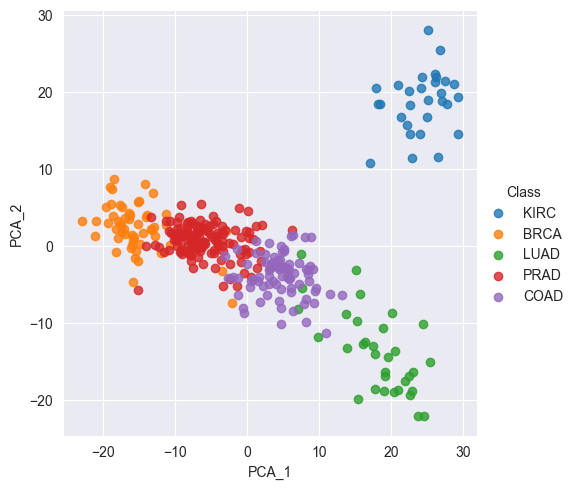

In [22]:
import seaborn as sns

sns.lmplot(data=eval_label, x='PCA_1', y='PCA_2', hue='Class', fit_reg=False)

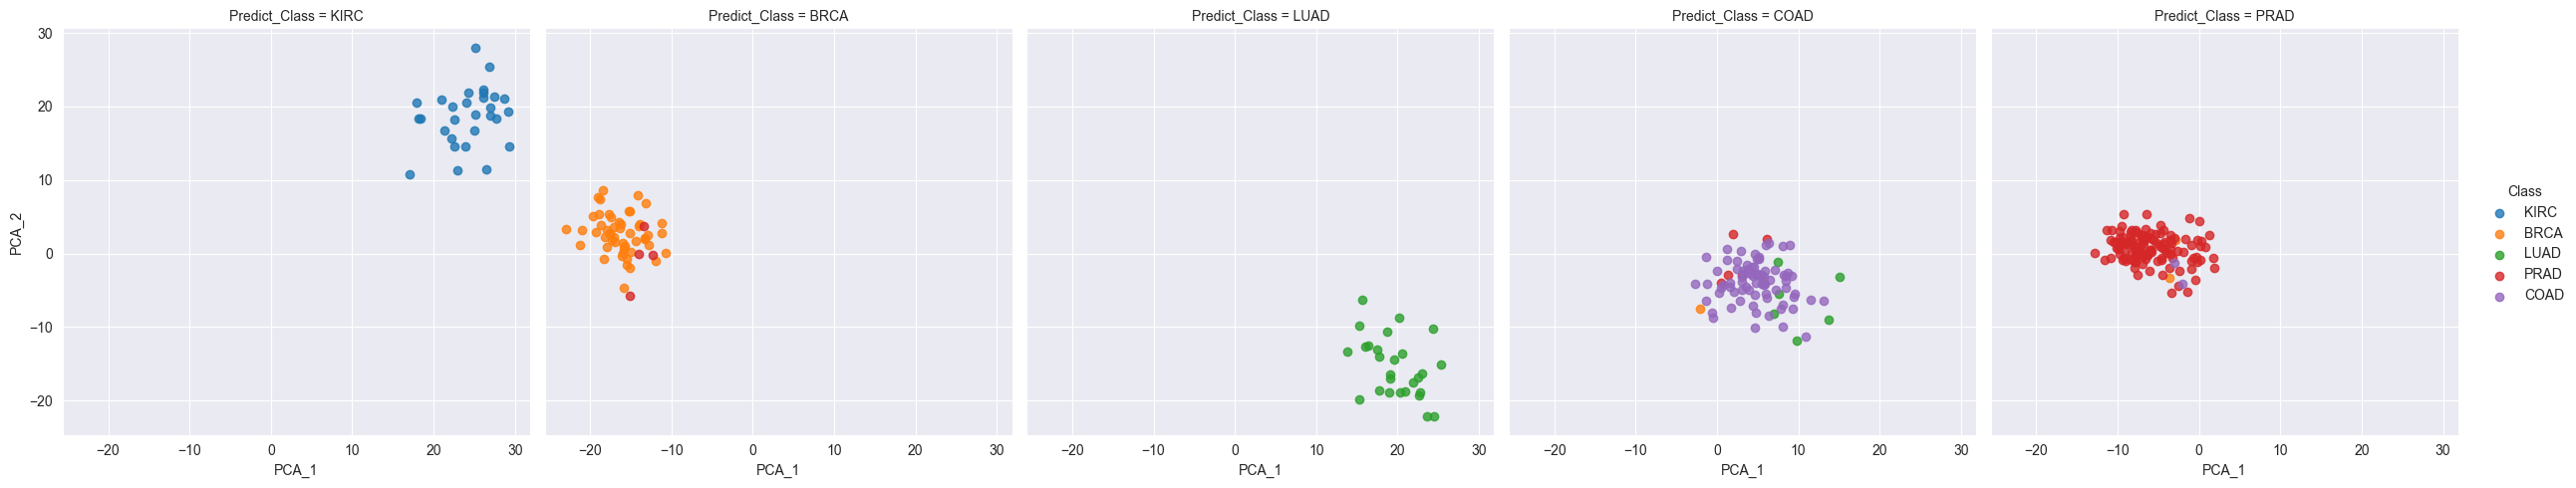

In [25]:
import seaborn as sns

sns.lmplot(data=eval_label, x='PCA_1', y='PCA_2', hue='Class', col='Predict_Class', fit_reg=False)